<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/getting_started_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference using IceVision

![](https://raw.githubusercontent.com/airctic/icevision/master/images/fridge-objects.png)

## Install IceVision
The following downloads and runs a short shell script. The script installs IceVision, IceData, the MMDetection library, and Yolo v5 as well
as the fastai and pytorch lightning engines.

In [ ]:
# !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
# !bash install_colab.sh

## Imports
All of the IceVision components can be easily imported with a single line.


In [ ]:
from icevision.all import *

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

In [ ]:
from mmcv.runner import load_checkpoint, save_checkpoint, _load_checkpoint

## Select a library, model, and backbone

In order to create a model, we need to:
* Choose one of the **libraries** supported by IceVision
* Choose one of the **models** supported by the library
* Choose one of the **backbones** corresponding to a chosen model

You can access any supported models by following the IceVision unified API, use code completion to explore the available models for each library.



### Creating a model
Selections only take two simple lines of code. For example, to try the mmdet library using the retinanet model and the resnet50_fpn_1x backbone  could be specified by:
```
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True)
```
As pretrained models are used by default, we typically leave this out of the backbone creation step.

We've selected a few of the many options below. You can easily pick which option you want to try by setting the value of `selection`. This shows you how easy it is to try new libraries, models, and backbones.


In [ ]:
# Just change the value of selection to try another model

selection = 0
image_size = 384

extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x
  # model_type = models.mmdet.vfnet
  # backbone = model_type.backbones.resnet50_fpn_mstrain_2x
  # extra_args['cfg_options'] = { 
  #   'model.bbox_head.loss_bbox.loss_weight': 2,
  #   'model.bbox_head.loss_cls.loss_weight': 0.8,
  #    }

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.mmdet.models.retinanet' from '/content/icevision/icevision/models/mmdet/models/retinanet/__init__.py'>,
 {})

In [ ]:
backbone.__dict__

{'config_path': Path('/root/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs/retinanet/retinanet_r50_fpn_1x_coco.py'),
 'model_name': 'retinanet',
 'weights_url': 'http://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r50_fpn_1x_coco/retinanet_r50_fpn_1x_coco_20200130-c2398f9e.pth'}


Now it is just a one-liner to instantiate the model. If you want to try another *option*, just edit the line at the top of the previous cell.

In [ ]:
# Instantiate the model with any pretrained weights
num_classes = 5
model_saved = model_type.model(backbone=backbone(pretrained=False), num_classes=num_classes, **extra_args) 

In [ ]:
path_to_folder = "samples/fridge/odFridgeObjects/images"
img_files = get_image_files(path_to_folder)
img_files

(#8) [Path('images/1.jpg'),Path('images/2.jpg'),Path('images/22.jpg'),Path('images/24.jpg'),Path('images/28.jpg'),Path('images/3.jpg'),Path('images/37.jpg'),Path('images/9.jpg')]

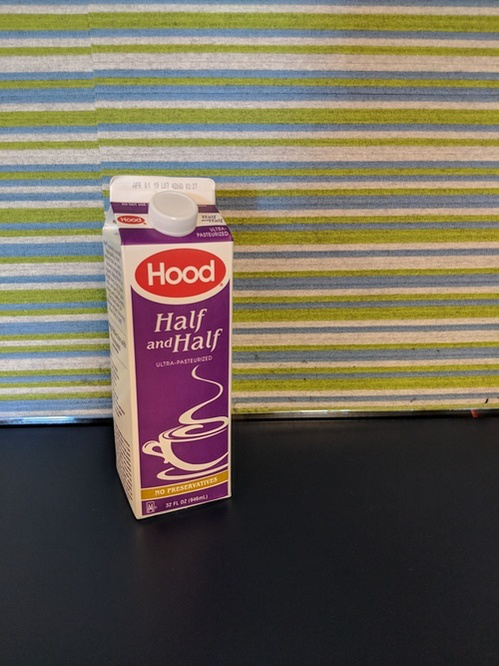

In [ ]:
img = PIL.Image.open(img_files[0])
img

In [ ]:
checkpoint_path = 'checkpoints/fridge-retinanet-save-checkpoint.pth'
# checkpoint_path = 'checkpoints/fridge-efficientdet-save-checkpoint.pth'

In [ ]:
checkpoint = load_checkpoint(model_saved, checkpoint_path)
model_saved.eval()

In [ ]:
checkpoint['meta']

{'classes': ['background', 'carton', 'milk_bottle', 'can', 'water_bottle'],
 'mmcv_version': '1.3.13',
 'time': 'Tue Sep 14 18:35:43 2021'}

In [ ]:
class_map_saved = ClassMap(checkpoint['meta']['classes'])
class_map_saved

<ClassMap: {'background': 0, 'carton': 1, 'milk_bottle': 2, 'can': 3, 'water_bottle': 4}>

In [ ]:
# Get class_map classes (labels): return a list
# This method should be added to ClassMap class for convenience
def get_classes(class_map):
    return class_map._id2class

# classes = parser.class_map.get_classes()
classes = get_classes(class_map_saved)
classes

['background', 'carton', 'milk_bottle', 'can', 'water_bottle']

In [ ]:
# Create a `meta` dict to pass to save_checkpoint: We can retrieve it when calling `load_checkpoint()` ethod
meta = {
    'classes': classes,
    'image_size': image_size,
    'model_type': f'{model_type}',
    'backbone': f'{backbone}',  
    }
meta

{'backbone': '<icevision.models.mmdet.models.retinanet.backbones.resnet_fpn.MMDetRetinanetBackboneConfig object at 0x7fac566e9950>',
 'classes': ['background', 'carton', 'milk_bottle', 'can', 'water_bottle'],
 'image_size': 384,
 'model_type': "<module 'icevision.models.mmdet.models.retinanet' from '/content/icevision/icevision/models/mmdet/models/retinanet/__init__.py'>"}

In [ ]:
checkpoint_path = 'checkpoints/fridge-retinanet-save-checkpoint-full.pth')
save_checkpoint(model_saved, checkpoint_path, meta=meta)

In [ ]:
checkpoint = _load_checkpoint(checkpoint_path)
checkpoint['meta']

Use load_from_local loader


{'backbone': '<icevision.models.mmdet.models.retinanet.backbones.resnet_fpn.MMDetRetinanetBackboneConfig object at 0x7fac566e9950>',
 'classes': ['background', 'carton', 'milk_bottle', 'can', 'water_bottle'],
 'image_size': 384,
 'mmcv_version': '1.3.13',
 'model_type': "<module 'icevision.models.mmdet.models.retinanet' from '/content/icevision/icevision/models/mmdet/models/retinanet/__init__.py'>",
 'time': 'Wed Sep 15 13:45:30 2021'}

In [ ]:
device=next(model_saved.parameters()).device)

device(type='cpu')

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [ ]:
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files]

infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map_saved)

In [ ]:
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)
preds_saved = model_type.predict_from_dl(model_saved, infer_dl, keep_images=True)

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


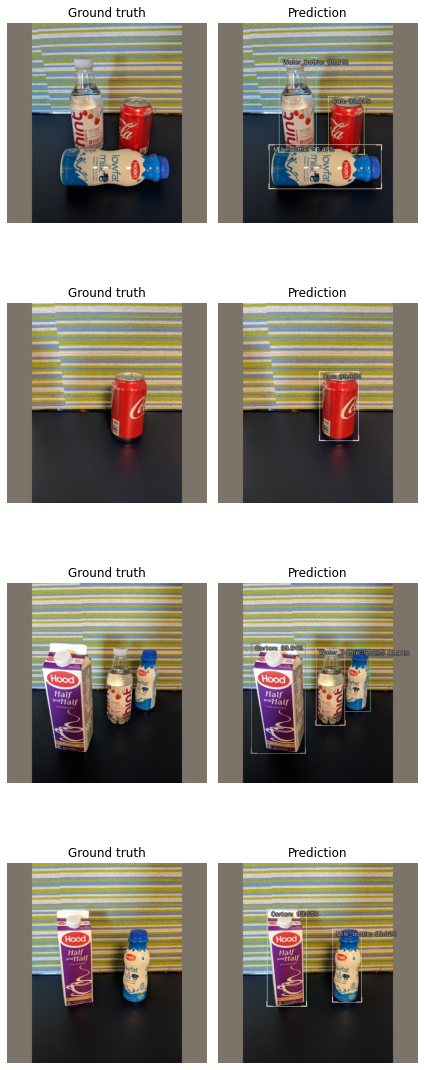

In [ ]:
show_preds(preds=preds_saved[4:8])

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).